In [37]:
from numba import cuda
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from PIL import Image

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
im = plt.imread("/content/drive/MyDrive/Colab Notebooks/image6.jpeg")

In [40]:
shape = np.shape(im)

In [41]:
filter = np.array(((0,0,1,2,1,0,0),
(0,3,13,22,13,3,0),
(1,13,59,97,59,13,1),
(2,22,97,159,97,22,2),
(1,13,59,97,59,13,1),
(0,3,13,22,13,3,0),
(0,0,1,2,1,0,0)))

In [42]:
total = sum(sum(filter))
total

1003

In [43]:
filter2 = filter/total
filter2

array([[0.        , 0.        , 0.00099701, 0.00199402, 0.00099701,
        0.        , 0.        ],
       [0.        , 0.00299103, 0.01296112, 0.0219342 , 0.01296112,
        0.00299103, 0.        ],
       [0.00099701, 0.01296112, 0.05882353, 0.09670987, 0.05882353,
        0.01296112, 0.00099701],
       [0.00199402, 0.0219342 , 0.09670987, 0.15852443, 0.09670987,
        0.0219342 , 0.00199402],
       [0.00099701, 0.01296112, 0.05882353, 0.09670987, 0.05882353,
        0.01296112, 0.00099701],
       [0.        , 0.00299103, 0.01296112, 0.0219342 , 0.01296112,
        0.00299103, 0.        ],
       [0.        , 0.        , 0.00099701, 0.00199402, 0.00099701,
        0.        , 0.        ]])

In [44]:
im2 = im.copy()

In [45]:
#first version CPU
"""
for x in range(3,shape[0]-3):
  for y in range(3,shape[1]-3):
    r = 0
    g = 0
    b = 0

    for ni, i in enumerate(range(-3,3)):
        for nj, j in enumerate(range(-3,3)):
          r+=(im[x+i,y+j,0]*filter2[ni,nj])
          g+=(im[x+i,y+j,1]*filter2[ni,nj])
          b+=(im[x+i,y+j,2]*filter2[ni,nj])

    im2[x,y,0] = r
    im2[x,y,1] = g
    im2[x,y,2] = b
"""

'\nfor x in range(3,shape[0]-3):\n  for y in range(3,shape[1]-3):\n    r = 0\n    g = 0\n    b = 0\n\n    for ni, i in enumerate(range(-3,3)):\n        for nj, j in enumerate(range(-3,3)):\n          r+=(im[x+i,y+j,0]*filter2[ni,nj])\n          g+=(im[x+i,y+j,1]*filter2[ni,nj])\n          b+=(im[x+i,y+j,2]*filter2[ni,nj])\n\n    im2[x,y,0] = r\n    im2[x,y,1] = g\n    im2[x,y,2] = b\n'

In [46]:
"""
imgpu = Image.fromarray(im2)
imgpu.save("/content/drive/MyDrive/Colab Notebooks/image_blur_CPU1.jpeg")
"""

'\nimgpu = Image.fromarray(im2)\nimgpu.save("/content/drive/MyDrive/Colab Notebooks/image_blur_CPU1.jpeg")\n'

In [47]:
im3 = im.copy()

In [48]:

#Second version CPU
def blurfunc(image):
  imagecopy = image
  for x in range(3,shape[0]-3):
    for y in range(3,shape[1]-3):
      rgb=[0,0,0]
      for ni, i in enumerate(range(-3,3)):
        for nj, j in enumerate(range(-3,3)):
          rgb+=(image[x+i,y+j]*filter2[ni,nj])
          
      imagecopy[x,y] = rgb

  return imagecopy  

'\n#Second version CPU\ndef blurfunc(image):\n  imagecopy = image\n  for x in range(3,shape[0]-3):\n    for y in range(3,shape[1]-3):\n      rgb=[0,0,0]\n      for ni, i in enumerate(range(-3,3)):\n        for nj, j in enumerate(range(-3,3)):\n          rgb+=(image[x+i,y+j]*filter2[ni,nj])\n          \n      imagecopy[x,y] = rgb\n\n  return imagecopy\n'

In [49]:

for i in range(10):
  im3 = blurfunc(im3)

imgpu = Image.fromarray(im3)
imgpu.save("/content/drive/MyDrive/Colab Notebooks/image_blur_CPU3.jpeg")


'\nfor i in range(10):\n  im3 = blurfunc(im3)\n\nimgpu = Image.fromarray(im3)\nimgpu.save("/content/drive/MyDrive/Colab Notebooks/image_blur_CPU3.jpeg")\n'

In [174]:
@cuda.jit
def blurgpu1(kernel, src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  r = 0
  g = 0
  b = 0

  for ni, i in enumerate(range(-3,3)):
    for nj, j in enumerate(range(-3,3)):
      r+= (src[tidx+i,tidy+j,0]*kernel[ni,nj])
      g+= (src[tidx+i,tidy+j,1]*kernel[ni,nj])
      b+= (src[tidx+i,tidy+j,2]*kernel[ni,nj])
  
  dst[tidx, tidy, 0 ] = np.uint8(r)
  dst[tidx, tidy, 1 ] = np.uint8(g)
  dst[tidx, tidy, 2 ] = np.uint8(b)

In [183]:
#GPU1
def GPUblurfunc(im, filter):
  devdata = cuda.to_device(im)
  devOuput = cuda.device_array(shape, np.uint8)
  kerneldev = cuda.to_device(filter)

  shape1 = np.shape(im)
  blockSize = (16,16)
  gridSize = (math.ceil(shape1[0]/blockSize[0]),math.ceil(shape1[1]/blockSize[1]))
  blurgpu1[gridSize, blockSize](kerneldev ,devdata, devOuput)

  result = devOuput.copy_to_host()

  return result

In [197]:
im3 = im.copy()

for i in range(10):
  im3 = GPUblurfunc(im3,filter2)

imgpu = Image.fromarray(im3)
imgpu.save("/content/drive/MyDrive/Colab Notebooks/image_blur_GPU.jpeg")

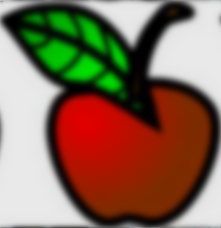

In [198]:
imgpu

#With shared filter

In [188]:
@cuda.jit
def blurgpu2(kernel, src, dst):
  tile = cuda.shared.array((7,7),np.float64)
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
 
  tile = kernel
  
  r = 0
  g = 0
  b = 0

  for ni, i in enumerate(range(-3,3)):
    for nj, j in enumerate(range(-3,3)):
      r+= (src[tidx+i,tidy+j,0]*tile[ni,nj])
      g+= (src[tidx+i,tidy+j,1]*tile[ni,nj])
      b+= (src[tidx+i,tidy+j,2]*tile[ni,nj])
  
  dst[tidx, tidy, 0 ] = np.uint8(r)
  dst[tidx, tidy, 1 ] = np.uint8(g)
  dst[tidx, tidy, 2 ] = np.uint8(b)

  cuda.syncthreads()

In [192]:
#GPU2
def GPUblurfunc2(im, filter):
  devdata = cuda.to_device(im)
  devOuput = cuda.device_array(shape, np.uint8)
  kerneldev = cuda.to_device(filter)

  shape1 = np.shape(im)
  blockSize = (16,16)
  gridSize = (math.ceil(shape1[0]/blockSize[0]),math.ceil(shape1[1]/blockSize[1]))
  blurgpu2[gridSize, blockSize](kerneldev ,devdata, devOuput)

  result = devOuput.copy_to_host()

  return result


In [199]:
im5 = im.copy()

for i in range(20):
  im5 = GPUblurfunc2(im5,filter2)

imgpu2 = Image.fromarray(im5)
imgpu2.save("/content/drive/MyDrive/Colab Notebooks/image_blur_GPU2.jpeg")

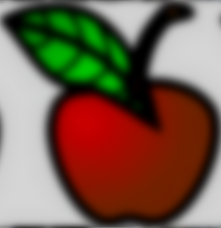

In [200]:
imgpu2